In [8]:
import numpy as np
import h5py
import swiftsimio as sw
import matplotlib.pyplot as plt
import pandas as pd
import os

In [19]:
import seaborn as sns
from matplotlib import cycler
import matplotlib as mpl
clrs = sns.color_palette('Set1')
clrs[5] = (255/255, 200/255, 80/255)
colors = cycler('color', list(clrs.as_hex()))
mpl.rc('font', family='serif')
mpl.rc('text', usetex=True)

plt.rc('axes', axisbelow=True, 
       grid=False, prop_cycle=colors)
plt.rc('xtick', direction='in')
plt.rc('ytick', direction='in')

In [9]:
# centers is a DataFrame with center coordinates for each volume
centers = pd.read_csv('centers.txt', names = ['vol_num','X','Y','Z'], index_col=0)

In [21]:
#_i is always index from the catalogue, 
#and _ids is id from the catalogue
class SimTools():
    def __init__(self, catalogue, snapshot, membership_file, siminfo_file, volume_num):
        self.catalogue_file = catalogue
        self.snapshot = snapshot
        self.membership_file = membership_file
        self.siminfo_file = siminfo_file
        self.mstar = None
        self.mtotal = None
        self.soap = h5py.File(self.catalogue_file, 'r') # Read in SOAP property file
        self.field = np.array(self.soap['VR/HostHaloID']) #all satellites have a host halo id that points towards the satellite
        self.vol = volume_num
        self.halo_ids = self.soap['VR/ID']
        self.host_halo_ids = np.array(self.soap['VR/ID'])[self.field==-1]
        self.host_halo_i = np.array(self.host_halo_ids)-1
        self.center = np.array([float(c) for c in centers.loc[self.vol]])
        
        with open(self.siminfo_file, 'r') as f:
            lines = f.readlines()
        for line in lines:
            if 'h_val' in line:
                parts = line.split()
                self.h_val = float(parts[2])
                break
        
    def getHaloMasses(self):
        self.mtotal = np.array(self.soap['BoundSubhaloProperties/TotalMass']) # Not m200 anymore
        try:
            self.mstar = np.array(self.soap['ExclusiveSphere/30kpc/StellarMass'])
        except KeyError:
            print('looking somewhere else')
            self.mtotal = np.array(self.soap['BoundSubhaloProperties/StellarMass'])

        return self.mtotal, self.mstar

    def getHaloDarkMatterMembers(self, halo_i):
        #halo INDEX is not halo ID
        # function to read in bound DM particles for a given halo
        members = h5py.File(self.membership_file, 'r') # Membership data
        host_halo_ids = np.array(members['PartType1/GroupNr_bound'])
        bound_particles = np.where(host_halo_ids == halo_i) # Find index of particles bound to given halo

        data = sw.load(self.snapshot) # Load snapshot data
        positions = data.dark_matter.coordinates # Coordinates of dark matter particles in simulation - can replace for gas, stars and properties like mass etc.
        self.positions = positions[bound_particles] # Mask for particles bound to given halo

        return self.positions

    def getHaloStarsMembers(self, halo_i):
        members = h5py.File(self.membership_file, 'r') # Membership data
        host_halo_ids = np.array(members['PartType4/GroupNr_bound']) # Gives the host halo ID that each particle is bound to
        bound_particles = np.where(host_halo_ids == halo_i) # Find index of particles bound to given halo

        data = sw.load(self.snapshot) # Load snapshot data
        positions = data.stars.coordinates # Coordinates of dark matter particles in simulation - can replace for gas, stars and properties like mass etc.
        self.star_positions = positions[bound_particles] # Mask for particles bound to given halo

        return self.star_positions
    
    def calc_r200(self, host_i):
        m200 = np.array(self.soap['SO/200_crit/TotalMass'])[host_i] #mass is in solar mass
        
        H = self.h_val*100 #converting from H/100 to h
        G = 4.3e-9 #converting from pc to Mpc
        rho_crit = 3*(H**2)/(8*np.pi*G)
        r200 = (m200/(4/3. * np.pi * 200*rho_crit))**(1/3)*1000
        return r200
            
    def make_volume_table(self):
        if self.mstar is None or self.mtotal is None:
            self.getHaloMasses()
        
        host_r200 = [self.calc_r200(i) for i in range(len(self.host_halo_i))]
        host_v200 = host_r200*self.h_val
        host_CoM = self.soap['BoundSubhaloProperties/CentreOfMass'][self.host_halo_i].tolist()
        host_tot_mass = [self.mtotal[i] for i in self.host_halo_i]
        host_stellar_mass = [self.mstar[i] for i in self.host_halo_i]
        #----new----
        host_corot = self.soap['ExclusiveSphere/30kpc/KappaCorotStars'][self.host_halo_i].tolist()
        host_atomicH = self.soap['ExclusiveSphere/30kpc/AtomicHydrogenMass'][self.host_halo_i].tolist()
        host_gasM = self.soap['BoundSubhaloProperties/GasMass'][self.host_halo_i].tolist()
        host_vmax = self.soap['BoundSubhaloProperties/MaximumCircularVelocity'][self.host_halo_i].tolist()
        host_v_vec = self.soap['BoundSubhaloProperties/CentreOfMassVelocity'][self.host_halo_i].tolist()
        host_halfM_radius = self.soap['ExclusiveSphere/30kpc/HalfMassRadiusStars'][self.host_halo_i].tolist()
        host_metalfrac = self.soap['ExclusiveSphere/30kpc/StellarMassFractionInMetals'][self.host_halo_i].tolist()
        host_ironfrac = self.soap['ExclusiveSphere/30kpc/StellarMassFractionInIron'][self.host_halo_i].tolist()
        host_vel_dispersion = self.soap['ExclusiveSphere/30kpc/StellarVelocityDispersionMatrix'][self.host_halo_i].tolist()
        #-------------
        sat_ids = [self.halo_ids[self.field == i].tolist() for i in self.host_halo_ids]
        sat_i = [(np.array(ids) - 1).tolist() for ids in sat_ids]
        sat_CoM = []
        sat_tot_mass = []
        sat_stellar_mass = []
        #---new---
        sat_atomicH = []
        sat_gasM = []
        sat_halfM_radius = []
        sat_metalfrac = []
        sat_ironfrac = []
        sat_vel_dispersion = []
        sat_vmax = []
        sat_v_vec = []
        #---------
        for i in sat_i:
            sat_CoM.append(self.soap['BoundSubhaloProperties/CentreOfMass'][i].tolist())
            sat_tot_mass.append(self.mtotal[i].tolist())
            sat_stellar_mass.append(self.mstar[i].tolist())
            #---new---
            sat_atomicH.append(self.soap['ExclusiveSphere/30kpc/AtomicHydrogenMass'][i].tolist())
            sat_gasM.append(self.soap['BoundSubhaloProperties/GasMass'][i].tolist())
            sat_halfM_radius.append(self.soap['ExclusiveSphere/30kpc/HalfMassRadiusStars'][i].tolist())
            sat_metalfrac.append(self.soap['ExclusiveSphere/30kpc/StellarMassFractionInMetals'][i].tolist())
            sat_ironfrac.append(self.soap['ExclusiveSphere/30kpc/StellarMassFractionInIron'][i].tolist())
            sat_vel_dispersion.append(self.soap['ExclusiveSphere/30kpc/StellarVelocityDispersionMatrix'][i].tolist())
            sat_vmax.append(self.soap['BoundSubhaloProperties/MaximumCircularVelocity'][i].tolist())
            sat_v_vec.append(self.soap['BoundSubhaloProperties/CentreOfMassVelocity'][i].tolist())
            #---------

        vol = [self.vol] * len(self.host_halo_i)


        data_dict = {
            'Volume': vol,
            'Host i': self.host_halo_i,
            'Host ID': self.host_halo_ids,
            'Host R200': host_r200,
            'Host V200': host_v200,
            'Host CoM': host_CoM,
            'Host Mtot': host_tot_mass,
            'Host M*': host_stellar_mass,
            'Host KappaCorot':host_corot,
            'Host Mhyd': host_atomicH,
            'Host Mgas':host_gasM,
            'Host HalfM* radius':host_halfM_radius,
            'Host M* Metal':host_metalfrac,
            'Host M* Iron':host_ironfrac,
            'Host vel': host_vel_dispersion,
            'Host Vmax': host_vmax,
            'Host CoMV': host_v_vec,
            'Sat i': sat_i,
            'Sat ID': sat_ids,
            'Sat CoM': sat_CoM,
            'Sat Mtot': sat_tot_mass,
            'Sat M*': sat_stellar_mass,
            'Sat Mhyd': sat_atomicH,
            'Sat Mgas':sat_gasM,
            'Sat HalfM* radius':sat_halfM_radius,
            'Sat M* Metal':sat_metalfrac,
            'Sat M* Iron':sat_ironfrac,
            'Sat vel': sat_vel_dispersion,
            'Sat Vmax': sat_vmax,
            'Sat CoMV': sat_v_vec,
        }

        df = pd.DataFrame(data_dict)
        self.main_df = df

        filename = f"data/volume_number_{self.vol}.csv"
        self.main_df.to_csv(filename, index=False)
        
        return self.main_df
    
    #=============PLOTS===============
    def plotBoxParticleDistribution(self):
        data = sw.load(self.snapshot) #read final snapshot
        pos = data.dark_matter.coordinates
        plt.figure(dpi=200)
        plt.plot(pos[::10,0], pos[::10,1],'k.', markersize=0.25, alpha=0.01)
        side_length = 5
        center_x = self.center[0]
        center_y = self.center[1]
        # Calculate the bottom left corner of the square
        bottom_left_x = center_x - side_length / 2
        bottom_left_y = center_y - side_length / 2

        # Square box around the center
        square_box = plt.Rectangle((bottom_left_x, bottom_left_y), side_length, side_length, edgecolor='r', facecolor='none')
        plt.gca().add_patch(square_box)
        plt.show()

    def plot_particles(self, host_i, df):
        host_halo_part = self.getHaloDarkMatterMembers(host_i)
        host_star_part = self.getHaloStarsMembers(host_i)
        sat_halo_part = []
        sat_star_part = []
        for i in df.loc[host_i]['Sat i']:
            sat_halo_part.append(self.getHaloDarkMatterMembers(i))
            sat_star_part.append(self.getHaloStarsMembers(i))    
        
        fig, ax = plt.subplots(1, 2, dpi=200, figsize = (12,7))
        ax[0].scatter(host_halo_part[::5,1], host_halo_part[::5,2], s=1, alpha = 0.2, c='black')
        ax[1].scatter(host_star_part[::5,1], host_star_part[::5,2], s=1, alpha = 0.2, c='black')
        for sat in sat_halo_part:
            ax[0].scatter(np.array(sat)[::5,1], np.array(sat)[::5,2], s=1, alpha=0.2, c='red')
        for sat in sat_star_part:
            ax[1].scatter(np.array(sat)[::5,1], np.array(sat)[::5,2], s=1, alpha=0.2, c='red')
        ax[1].set_title(f'Star particles of halo {host_i+1} and satellites')
        ax[0].set_title(f'Dark matter particles of halo {host_i+1} and satellites')
        fig.show()

In [11]:
#!!!DO NOT RUN
'''
vols = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25']
for v in vols:
    SOAP_fname = f'/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume{v}/SOAP_halo_properties_0063.hdf5'
    SOAP_membership = f'/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume{v}/SOAP_membership_0063.hdf5'
    snapshot = f'/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume{v}/snapshot_0063.hdf5'
    siminfo_file = f'/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume{v}/halo_0063.siminfo'
    vol_sim = SimTools(SOAP_fname, snapshot, SOAP_membership, siminfo_file, v)
    vol_main_df = vol_sim.make_volume_table()

'''

"\nvols = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25']\nfor v in vols:\n    SOAP_fname = f'/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume{v}/SOAP_halo_properties_0063.hdf5'\n    SOAP_membership = f'/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume{v}/SOAP_membership_0063.hdf5'\n    snapshot = f'/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume{v}/snapshot_0063.hdf5'\n    siminfo_file = f'/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume{v}/halo_0063.siminfo'\n    vol_sim = SimTools(SOAP_fname, snapshot, SOAP_membership, siminfo_file, v)\n    vol_main_df = vol_sim.make_volume_table()\n\n"

In [12]:
#!!!ONLY RUN ONCE

# Assuming combined_plotsim is already defined and has attributes main_df and sat_cols
'''
central_dfs = []

for vol in combined_plotsim.main_df['Volume'].unique():
    center = np.array([float(c) for c in centers.loc[vol]])
    
    # Get massive host halos within 5 Mpc of volume center
    central_df = combined_plotsim.main_df.loc[(combined_plotsim.main_df['Volume'] == vol) & (combined_plotsim.main_df['Host M*'] > 1e9)]
    
    # Distance mask for host halos
    center_distance_mask = [all(np.abs(host_com - center) < 5) for host_com in central_df['Host CoM']]
    
    # Apply mask to central_df
    central_df = central_df.loc[center_distance_mask]
    
    for i in central_df.index:
        # Distance cut for satellites
        r200 = central_df.at[i, 'Host R200']
        host_center = np.array(central_df.at[i, 'Host CoM'])
        satellite_centers = np.array(central_df.at[i, 'Sat CoM'])
        
        distances = np.array([np.linalg.norm(sat - host_center) for sat in satellite_centers]) * 1000
        distance_mask = distances < r200
        
        for col in combined_plotsim.sat_cols:
            central_df.at[i, col] = np.array(central_df.at[i, col])[distance_mask].tolist()
    
    # Append the processed central_df to the list
    central_dfs.append(central_df)

# Combine all central dataframes into one
combined_central_df = pd.concat(central_dfs, ignore_index=True)
combined_central_df.to_csv('combined_central_df.csv', index=False)
'''

"\ncentral_dfs = []\n\nfor vol in combined_plotsim.main_df['Volume'].unique():\n    center = np.array([float(c) for c in centers.loc[vol]])\n    \n    # Get massive host halos within 5 Mpc of volume center\n    central_df = combined_plotsim.main_df.loc[(combined_plotsim.main_df['Volume'] == vol) & (combined_plotsim.main_df['Host M*'] > 1e9)]\n    \n    # Distance mask for host halos\n    center_distance_mask = [all(np.abs(host_com - center) < 5) for host_com in central_df['Host CoM']]\n    \n    # Apply mask to central_df\n    central_df = central_df.loc[center_distance_mask]\n    \n    for i in central_df.index:\n        # Distance cut for satellites\n        r200 = central_df.at[i, 'Host R200']\n        host_center = np.array(central_df.at[i, 'Host CoM'])\n        satellite_centers = np.array(central_df.at[i, 'Sat CoM'])\n        \n        distances = np.array([np.linalg.norm(sat - host_center) for sat in satellite_centers]) * 1000\n        distance_mask = distances < r200\n        \

In [ ]:
SOAP_fname = '/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume15/SOAP_halo_properties_0063.hdf5'
SOAP_membership = '/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume15/SOAP_membership_0063.hdf5'
snapshot = '/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume15/snapshot_0063.hdf5'
siminfo = '/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume15/halo_0063.siminfo'

vol15_simtools = SimTools(SOAP_fname, snapshot, SOAP_membership, siminfo, 15)

vol15_df = pd.read_csv('data/volume_number_15.csv', converters={'Host CoM':pd.eval, 
            'Host CoMV':pd.eval, 
            'Sat ID':pd.eval, 
            'Sat i':pd.eval, 
            'Sat Mtot':pd.eval, 
            'Sat M*':pd.eval, 
            'Sat CoM': pd.eval, 
            'Sat Mhyd': pd.eval,
            'Sat Mgas':pd.eval,
            'Sat HalfM* radius':pd.eval,
            'Sat M* Metal':pd.eval,
            'Sat M* Iron':pd.eval,
            'Sat vel': pd.eval,
            'Sat Vmax': pd.eval,
            'Sat CoMV': pd.eval})


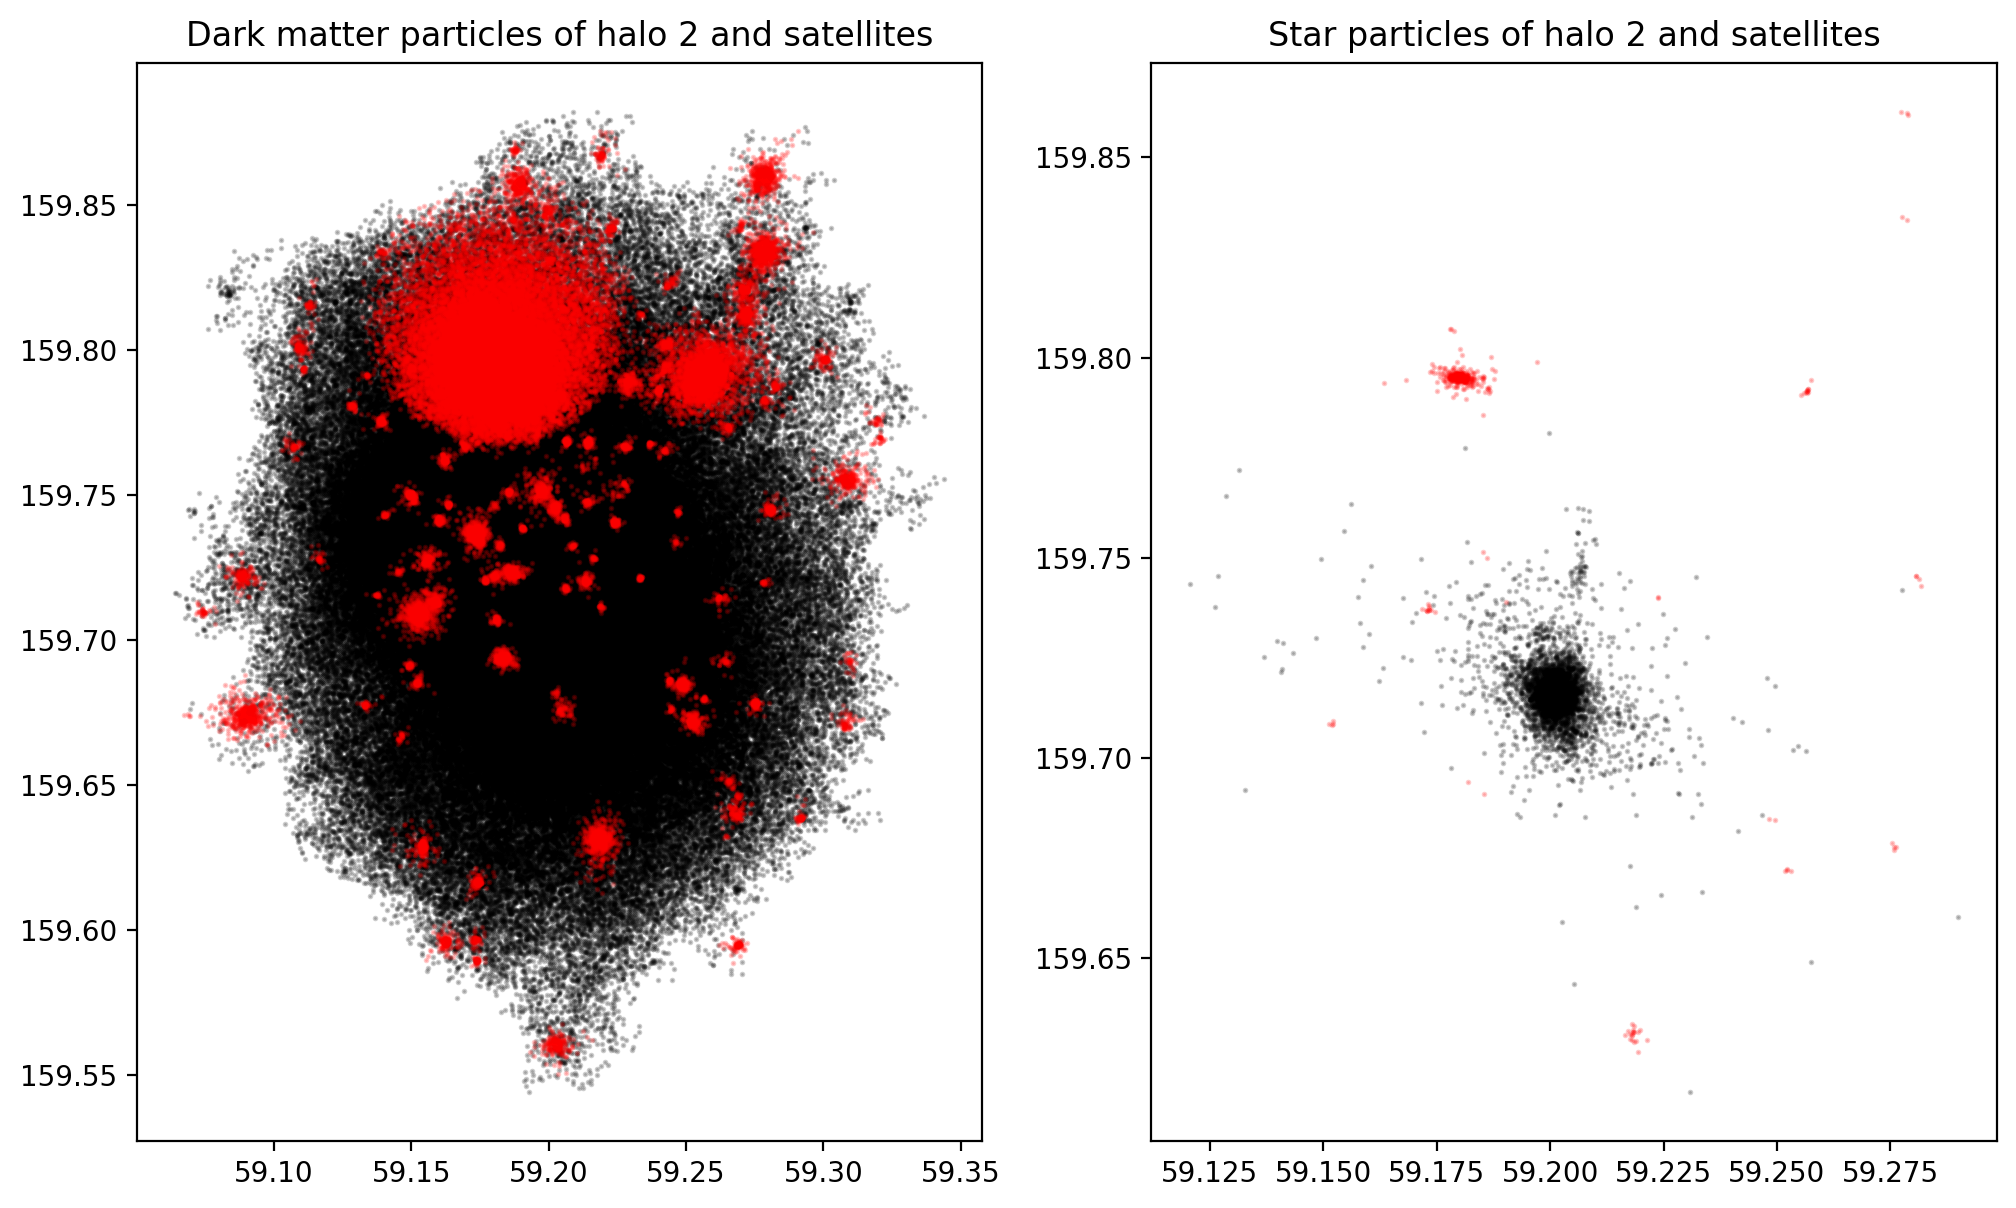

In [14]:
vol15_simtools.plot_particles(0, vol15_df)
vol15_simtools.plot_particles(1, vol15_df)

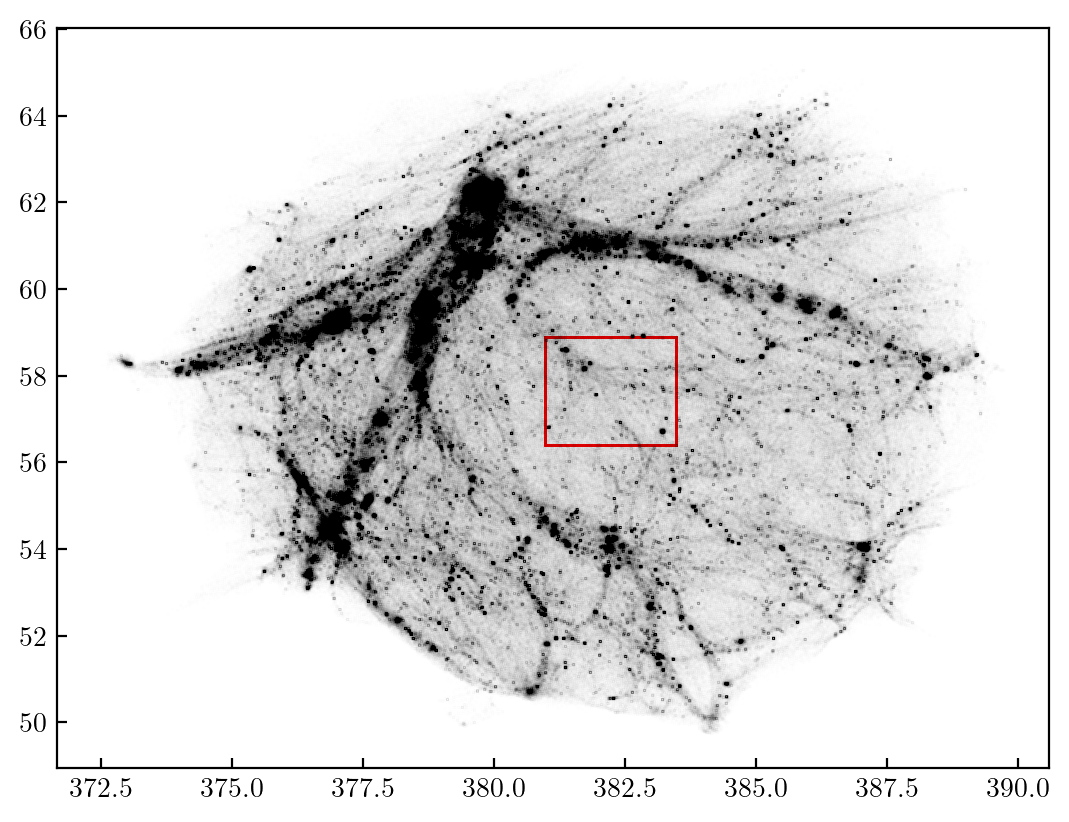

In [27]:
vol15_simtools.plotBoxParticleDistribution()